# IA Identification of Medicines - ML Algorithm

## Importing necessary libraries

In [ ]:
from google.colab import drive


drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from __future__ import print_function, division
import torchvision.models as models
import torch.nn as nn
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, datasets, models 
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

## DATA IMPORT AND PRE-PROCESSING 

In [ ]:
data_transforms = {

"train": transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(),
transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
]),

"val" : transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
]),

"test": transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
]) 
}

data_dir = 'gdrive/My Drive/final_dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
data_transforms[x]) for x in ["train", "val"]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
shuffle=True, num_workers=4) for x in ["train", "val"]}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]} 
class_names = image_datasets["train"].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_datasets = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms["test"])
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=32, shuffle=True, num_workers=4)


In [ ]:
print("Train images: " + str(len(image_datasets['train'].targets)))
print("Val images: " + str(len(image_datasets['val'].targets)))
print("Test images: " + str(len(test_datasets.targets)))

Train images: 900
Val images: 273
Test images: 150


# Change Model

In [ ]:
# Pre-trained models
model = models.vgg16(pretrained=True)

# Visualizing VGG model
model = model.cuda()
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Create new classifier for model using torch.nn as nn library
classifier_input = model.classifier[0].in_features
num_labels = len(class_names)

classifier = nn.Sequential(nn.Linear(classifier_input, 4096),
                           nn.ReLU(),
                           nn.Dropout(),
                           nn.Linear(4096, 1024),
                           nn.ReLU(),
                           nn.Dropout(),
                           nn.Linear(1024, num_labels),
                           nn.LogSoftmax(dim=1))

# Replace default classifier with new classifier
model.classifier = classifier

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## MODEL Training

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Initialing best model copy & variables
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = -1

    # Using GPU if available
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        print('using gpu')
        model.cuda()

    # Initializing arrays to hold accuracy and
    # loss values at each epoch
    losses = dict()
    losses['train'] = np.ones(num_epochs)
    losses['val'] = np.ones(num_epochs)
    accs = dict()
    accs['train'] = np.ones(num_epochs)
    accs['val'] = np.ones(num_epochs)

    # Iterating over epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # If in training: train
            else:
                model.eval()   # If in validation: evaluate

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                if train_on_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()

                # Zero gradients
                optimizer.zero_grad()

                # Forward propagation
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward propagation & Optimization
                    # (Only if in training phase)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            losses[phase][epoch] = epoch_loss
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            accs[phase][epoch] = epoch_acc

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy model if best val accuracy thus far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch

        print()

    # Printing statistics while model trains
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best epoch: {:4f}'.format(best_epoch))

    # Load best model at the end of training
    model.load_state_dict(best_model_wts)
    return model, losses, accs



## MODEL PARAMETERS


In [ ]:
LEARNING_RATE = 0.005
DECAYING_FACTOR = .9 
STEP_SIZE = 3
NUM_EPOCHS = 25

In [ ]:

criterion = nn.CrossEntropyLoss()

# Employing SGD as Optimizer
optimizer_ft = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# Decay LR by a factor of $DECAYING_FACTOR every $STEP_SIZE epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=STEP_SIZE, gamma=DECAYING_FACTOR)
model, losses, accs = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

using gpu
Epoch 0/24
----------
train Loss: 1.9819 Acc: 0.2089
val Loss: 1.5767 Acc: 0.3223

Epoch 1/24
----------
train Loss: 1.4249 Acc: 0.4511
val Loss: 1.4590 Acc: 0.4872

Epoch 2/24
----------
train Loss: 1.1716 Acc: 0.5289
val Loss: 0.8934 Acc: 0.6374

Epoch 3/24
----------
train Loss: 0.8609 Acc: 0.6722
val Loss: 0.9925 Acc: 0.6190

Epoch 4/24
----------
train Loss: 0.7551 Acc: 0.6989
val Loss: 0.5802 Acc: 0.7363

Epoch 5/24
----------
train Loss: 0.5376 Acc: 0.7856
val Loss: 1.9079 Acc: 0.5128

Epoch 6/24
----------
train Loss: 1.4022 Acc: 0.4789
val Loss: 1.3176 Acc: 0.4359

Epoch 7/24
----------
train Loss: 1.0184 Acc: 0.5744
val Loss: 0.8413 Acc: 0.6081

Epoch 8/24
----------
train Loss: 0.6894 Acc: 0.7167
val Loss: 0.9751 Acc: 0.6630

Epoch 9/24
----------
train Loss: 0.5572 Acc: 0.7656
val Loss: 0.5544 Acc: 0.7619

Epoch 10/24
----------
train Loss: 0.5216 Acc: 0.7844
val Loss: 0.6284 Acc: 0.7692

Epoch 11/24
----------
train Loss: 0.4344 Acc: 0.8367
val Loss: 0.7410 Acc: 

## Model Testing

In [ ]:
def test(model, criterion):
    test_loss = 0.
    correct = 0.
    total = 0.

    # Using GPU
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        model.cuda()

    # Iterating through test batches
    for batch_idx, (data, target) in enumerate(test_dataloader):

            if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                    
            # Forward pass
            output = model(data)

            # Loss calculation
            loss = criterion(output, target) 
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))

            # Convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]

            # Compare predicted and true labels
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: {:.6f}% ({:.0f}/{:.0f})'.format(100. * correct / total, correct, total))
    
test(model, criterion)

Test Loss: 0.443335


Test Accuracy: 82.666667% (124/150)


## Learning Curves

In [ ]:
plt.rcParams.update({'font.size': 24})

ref ='Complex_LR_' + str(LEARNING_RATE) + '_DF_' + str(DECAYING_FACTOR) + '_Step_' + str(STEP_SIZE)

def plot_acc_curve(accs, num_epochs):
    plt.figure(1, figsize=(8, 8))
    plt.plot(range(1,num_epochs+1), accs['train']*100, '-ro', label='Training Accuracy')
    plt.plot(range(1,num_epochs+1), accs['val']*100, '-bo', label='Validation Accuracy')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend()
    #plt.ylim(25,100)
    plt.ylim(20,100)
    plt.tight_layout()
    plt.savefig('Acc_' + ref + '.png')

def plot_loss_curve(losses, num_epochs):
    plt.figure(1, figsize=(8, 8))
    plt.plot(range(1,num_epochs+1), losses['train'], '-ro', label='Training Loss')
    plt.plot(range(1,num_epochs+1), losses['val'], '-bo', label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    #plt.ylim(0,2.2)
    plt.ylim(0,2.5)
    plt.tight_layout()
    plt.savefig('Loss_' + ref + '.png')

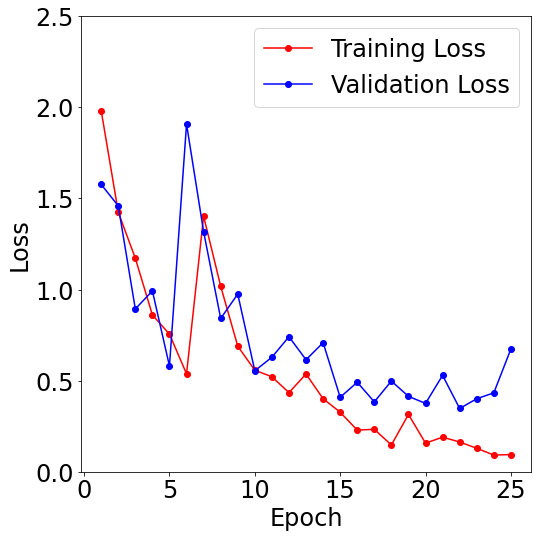

In [ ]:
plot_loss_curve(losses, 25)

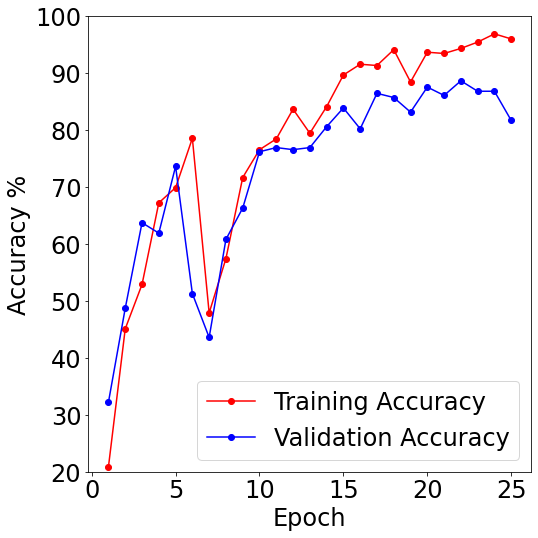

In [ ]:

plot_acc_curve(accs, 25)

In [ ]:
from google.colab import files
files.download('Loss_' + ref + '.png') 
files.download('Acc_' + ref + '.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Reduce batch size if necessary
# Must run if shuffle not set to False previosuly in Data Processing
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'),data_transforms['test'])
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=False, num_workers=4)

In [ ]:

# Delete CUDA memory if necessary
torch.cuda.empty_cache()
del dataloaders

In [ ]:
 #Compute predictions on Test set
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).cuda()
    for batch in loader:
        images, labels = batch
        preds = model(images.cuda())
        torch.cuda.empty_cache()
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        ).cuda()
    return all_preds

test_preds = get_all_preds(model, test_dataloader)

In [ ]:

# Assign targets to variables
real_target = torch.LongTensor(test_datasets.targets).cuda()
pred_target = test_preds.argmax(dim=1)

In [ ]:

# Create array with confusion matrix values

stacked = torch.stack((real_target, pred_target), dim=1)
cmt = torch.zeros(num_labels, num_labels, dtype=torch.int64)

for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

print(cmt)

tensor([[13,  1,  0,  1,  0,  0,  0,  7],
        [ 1, 15,  0,  0,  0,  0,  0,  6],
        [ 0,  0,  8,  0,  1,  0,  0,  0],
        [ 0,  0,  0, 21,  0,  0,  0,  1],
        [ 0,  0,  0,  0, 21,  0,  1,  0],
        [ 0,  0,  0,  3,  0, 18,  1,  0],
        [ 0,  0,  0,  0,  0,  0, 22,  0],
        [ 2,  0,  0,  1,  0,  0,  0,  6]])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

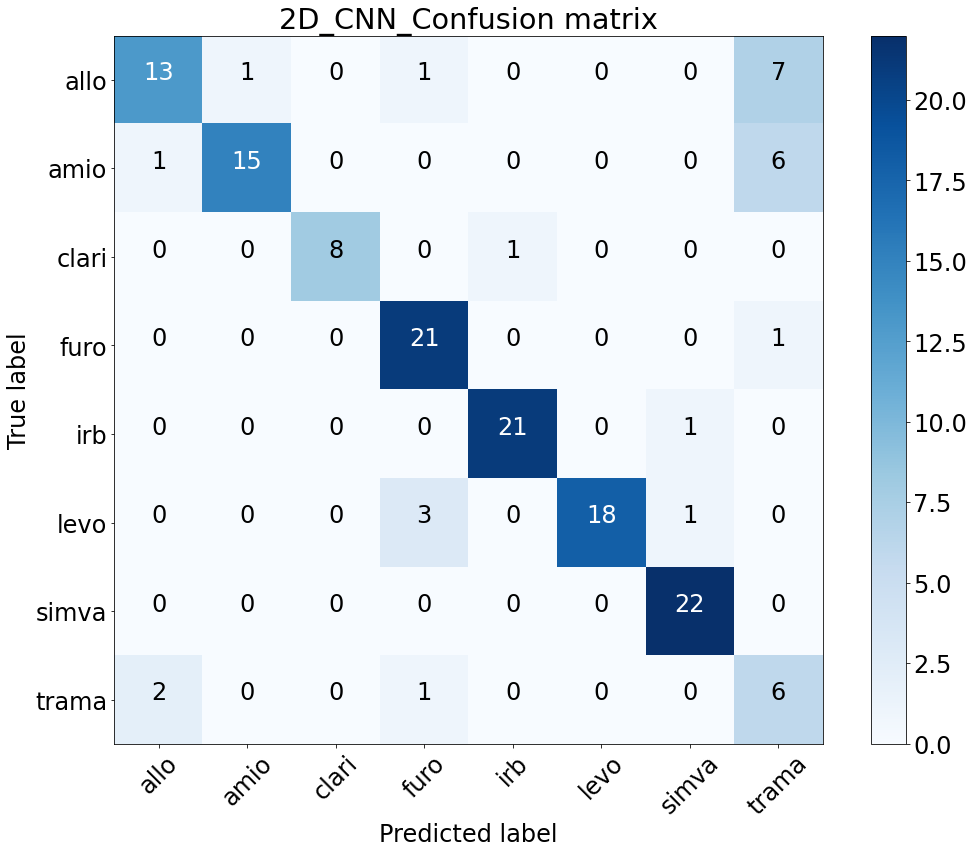

In [ ]:

# Plot confusion matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='2D_CNN_Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(1, figsize=(15, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('CM_' + ref + '.png')

plot_confusion_matrix(cmt, class_names)
files.download('CM_' + ref + '.png')

In [ ]:
# Saving model for mobile application
path = F"/content/gdrive/My Drive/2DCNN_RGB_model_final_2.pt"
torch.save(model.state_dict(), path)